# Trajectory construction based on 10DOF IMU

This example shows how to use the [10DOF IMU sensor](http://www.dfrobot.com.cn/goods-1860.html) and the automoto module to construct trajectory of the car.

For this notebook, a PYNQ Arduino is required, and the IMU sensor should connect to the I2C interface.

### 1. Load overlay

In [1]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay("Robot.bit")

### 2. Read single axis data and control the car to move
This example shows on how to get a Axis data from the 10DOF IMU sensor.

10DOF IMU sensor contains accelerometer, gyroscope and magnetometer, which can provides real-time raw sample of the sensed acceleration, angular rate and magnetic field.

In [2]:
import math
from pynq.lib.arduino import RUN_IMU
from time import sleep

PINS = [5,6,4,7,3,2,9,8,11,10,13,12]
IMU = RUN_IMU(base.ARDUINO, PINS)

There are six moving model provided, each model can adjust velocity freely

In [4]:
DIRECTION = ["FORWARD","BACKWARD",
             "LEFT_S","RIGHT_S",
             "LEFT_R","RIGHT_R"]

The raw data can also be retrieved from the IMU

In [5]:
[ax, ay, az, gx, gy, gz, mx, my, mz] = IMU.get_axis()
print("Acceleration is",float("{0:.2f}".format(ax)),float("{0:.2f}".format(ay)),float("{0:.2f}".format(az)))
print("Angular rate is",float("{0:.2f}".format(gx)),float("{0:.2f}".format(gy)),float("{0:.2f}".format(gz)))
print("Magnetic field is",float("{0:.2f}".format(mx)),float("{0:.2f}".format(my)),float("{0:.2f}".format(mz)))

Acceleration is -47.0 -41.0 972.0
Angular rate is 0.0 0.19 0.12
Magnetic field is -100.5 -11.88 19.5


input the direction into motor.move() function, the default power is set as 50%

and the range of power is from 0 - 100 (unit: percent)

e.g.
* motor.move("FORWARD") legal
* motor.move("BACKWARD", 60) legal
* motor.move("backward") illegal
* motor.move("LEFT_S",101) illegal

In [6]:
IMU.move("FORWARD", 50)# 50 is the power of the motor
sleep(2)
IMU.stop()

In [7]:
print('Left motor has covered distance: ',IMU.distance(1,1))
print('Right motor has covered distance: ',IMU.distance(1,2))

Left motor has covered distance:  0.5552105827083332
Right motor has covered distance:  0.5338085008333333


### 3. Advanced: Trajectory construction
The 10DOF IMU sensor possess a on-chip MCU which can calculate the Euler angle and Quaternion based on the information from the three sensors which may relieve the user's work on sensor fusion.This example shows how to get the data from the sensor.

In [8]:
[head, roll, pitch] = IMU.get_eul()
print("The Euler angle-- Head:",float("{0:.2f}".format(head)),"Roll:",float("{0:.2f}".format(roll)),"Pitch:",float("{0:.2f}".format(pitch)))

The Euler angle-- Head: 0.06 Roll: -2.62 Pitch: -2.38


In [9]:
[w, x, y, z] = IMU.get_qua()
print("The Quaternion-- w:",w,"x:",x,"y:",y,"z:",z)

The Quaternion-- w: 1.0 x: -0.02 y: 0.02 z: -0.01


Although we can obtain the Euler angle and Quaternion, but we actually don't know what the orientation of the car is. You may imagine where the car point to by using the Euler angle. But with the Quaternion? No way!

Therefore, the demo below can visualize the IMU's orientation at reat time.

Firstly, initialize the [matplotlib](https://matplotlib.org/index.html) before visualization.

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
#from IPython import display
import numpy as np

A **qua2vec** function can help us "translate" the quaternion.It receive a vector in the sensor's reference frame, rotate it to the Earth's reference frame and output.

In the next demo, we demonstrate the ability of trajectory reconstruction based on odometry and IMU.
We use two threads to control the car remotely and construct the trajectory. The main thread receives control command from the remote control client on host PC. The display thread run in a forever loop to reconstruct the trajectory and update the animation. The left figure shows the orientation of the sensor, the right figure displays the reconstructed trajectory.
<img src="data/Trajectory.png" width="600px"/>
One thing should be noticed is that, the update process is so slow due to the slow painting. So it **won't** construct a very accurate trajectory if you move and rotate the robot car too fast.

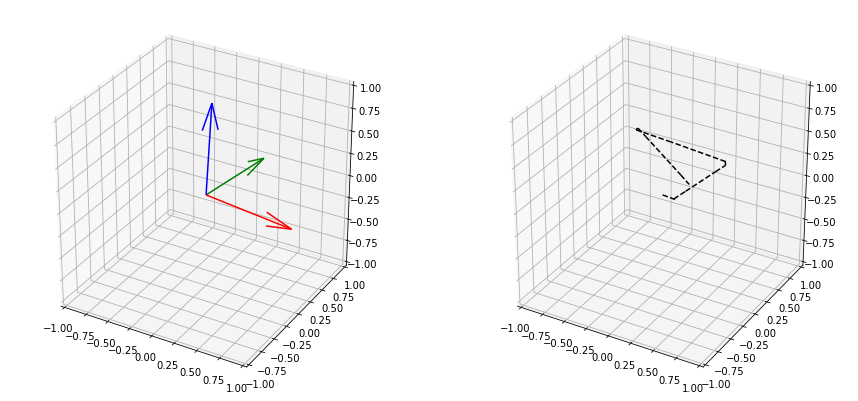

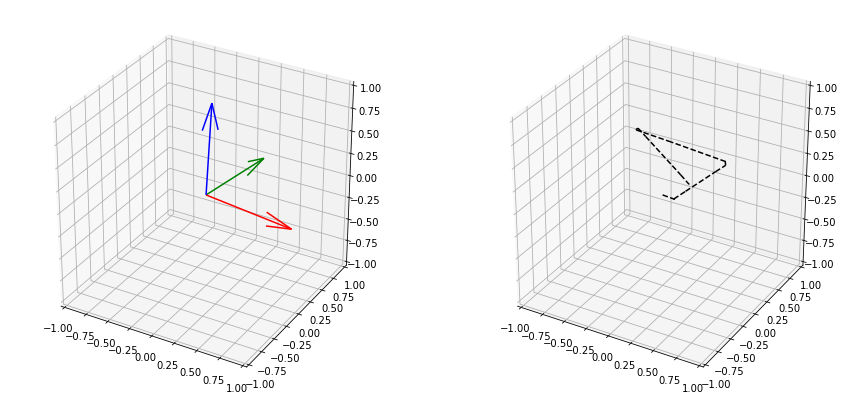

In [10]:
import threading
import socket
from IPython import display

plt.ion()
plt.rcParams['figure.figsize'] = (15.0, 12.0)
fig = plt.figure(1)
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlim3d(-1, 1)
ax.set_ylim3d(-1, 1)
ax.set_xlim3d(-1, 1)
ax.set_aspect("equal")
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_zlim3d(-1, 1)
ax2.set_ylim3d(-1, 1)
ax2.set_xlim3d(-1, 1)
ax2.set_aspect("equal")

def qua2vec(qua, a_x, a_y, a_z):
    a_xe = 2*a_x * (0.5 - qua[2] * qua[2] - qua[3] * qua[3]) + 2*a_y * (qua[1]*qua[2] - qua[0]*qua[3]) + 2*a_z * (qua[1]*qua[3] + qua[0]*qua[2]);
    a_ye = 2*a_x * (qua[1]*qua[2] + qua[0]*qua[3]) + 2*a_y * (0.5 - qua[1] * qua[1] - qua[3] * qua[3]) + 2*a_z * (qua[2]*qua[3] - qua[0]*qua[1]);
    a_ze = 2*a_x * (qua[1]*qua[3] - qua[0]*qua[2]) + 2*a_y * (qua[2]*qua[3] + qua[0]*qua[1]) + 2*a_z * (0.5 - qua[1] * qua[1] - qua[2] * qua[2]);
    return [a_xe, a_ye, a_ze]

class DisplayThread (threading.Thread):
    def __init__(self):
        super(DisplayThread, self).__init__()
        self.__running = threading.Event()      # 用于停止线程的标识
        self.__running.set()
    def run(self):
        nowx = 0
        nowy = 0
        nowz = 0
        q0 = None
        while self.__running.isSet():
            qua = IMU.get_qua()
            dis = (IMU.distance(0,1) + IMU.distance(0,2)) / 2;
            IMU.distance(1,1);
            IMU.distance(1,2);
            if not q0 is None:
                q0.remove()
                q1.remove()
                q2.remove()
            [a_xe, a_ye, a_ze] = qua2vec(qua, 1, 0, 0);
            q0 = ax.quiver(0, 0, 0, a_xe, a_ye, a_ze, color='red', length=1.0)
            [a_xe, a_ye, a_ze] = qua2vec(qua, 0, 1, 0);
            q1 = ax.quiver(0, 0, 0, a_xe, a_ye, a_ze, color='green', length=1.0)
            [a_xe, a_ye, a_ze] = qua2vec(qua, 0, 0, 1);
            q2 = ax.quiver(0, 0, 0, a_xe, a_ye, a_ze, color='blue', length=1.0)

            [a_xe, a_ye, a_ze] = qua2vec(qua, dis, 0, 0);
            ax2.plot([nowx, nowx+a_xe], [nowy, nowy+a_ye], [nowz, nowz+a_ze], 'k--')
            nowx = nowx + a_xe
            nowy = nowy + a_ye
            nowz = nowz + a_ze

            display.clear_output(wait=True)
            display.display(fig)
    def stop(self):
        self.__running.clear()

thread1 = DisplayThread()
thread1.start()

ip_port = ('172.29.80.2',8484)
web = socket.socket()
web.bind(ip_port)
web.listen(5)
conn,addr = web.accept()
while True:
    data = conn.recv(1024)
    if (data == b'FORWARD'):
        IMU.move("FORWARD", 50)# 50 is the power of the motor
    elif (data == b'BACKWARD'):
        IMU.move("BACKWARD", 50)
    elif (data == b'LEFT_R'):
        IMU.move("LEFT_R", 80)
    elif (data == b'RIGHT_R'):
        IMU.move("RIGHT_R", 80)
    elif (data == b'LEFT_S'):
        IMU.move("LEFT_S", 80)
    elif (data == b'RIGHT_S'):
        IMU.move("RIGHT_S", 80)
    elif (data == b'STOP'):
        IMU.stop()
    elif (data == b'EXIT'):
        IMU.stop()
        break

conn.close()
web.close()
thread1.stop()